In [1]:
# importing necessary libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import time
import json
'''
Doing tests in jupyter before I export them to code, so i can play around, explore,
and think things out!


Have fun, explain things out like your a teacher!
'''

'''
Keeping gradients for all nodes so we can derive expressions by scratch!
'''


# To-DO
# / load/save parameters, hyperparameters from hugging face and own model!
# / Remove parameters/autograd
# / Fuse multihead attention w/ 4d Tensors
# / 


'\nKeeping gradients for all nodes so we can derive expressions by scratch!\n'

In [2]:
# tokenizing! --> GPT-4 tokenizer copy
import tokenization
import regex # dependency

# training tokenizer
with open('stephen_king\king.txt', 'r',encoding="utf-8") as f:
    text = f.read()

t = tokenization.Tokenizer() # GPT-4 trainer for tokens!
##t.train(text,700)#### only do to modify vocab size: takes forever!

# encoding text
##t.encode(text,'encoding2.txt') # encodes to file --> king bpe
encoded_txt = t.load_encoding('encoding2.txt')

<>:6: SyntaxWarning: invalid escape sequence '\k'
<>:6: SyntaxWarning: invalid escape sequence '\k'
C:\Users\charl\AppData\Local\Temp\ipykernel_10336\14278197.py:6: SyntaxWarning: invalid escape sequence '\k'
  with open('stephen_king\king.txt', 'r',encoding="utf-8") as f:


In [3]:
chunk_size = 1
split_ratio = 0.9
context_length = 350
n_embd = 258
batch_size = 32 # testing
n_heads = 6
dropout_rate = 0.2

In [4]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

print(device)

cuda


In [5]:
# Generating data, see textdata.py
chars = sorted(list(set(encoded_txt))) # list of all characters possible, use encode/decode for them
vocab_size= max(chars) + 1 # num of dims we should have
print(vocab_size)

x_train = encoded_txt
y_train = encoded_txt[1:]

x_train = torch.tensor(x_train,device=device)
y_train = torch.tensor(y_train,device=device)

# need x_train, y_train
# re-write evaluation pipleline to be actually good!

def get_batch(b,t): # get batch from x!
    xid = torch.randint(len(x_train)-t-1,size=(b,),device=device) # getting random batches!
    batchx = torch.cat([x_train[xid[i]:xid[i]+t] for i in range(b)]).view(b,t)
    batchy = torch.cat([y_train[xid[i]:xid[i]+t] for i in range(b)]).view(b,t)
    return batchx,batchy

get_batch(20,2)
print(vocab_size)

597
597


In [16]:

'''
To-Do:
- multihead attention (parallelism?)
- residual connections and gradients
- layer norm and gradients
- dropout and gradients
- optimizing model overall? / seeing how compares to torch

'''




'''
Backprop - Each block/layer has it's own backpropogation. We'll build upon these, and have lower layers
'pass their gradients through'.

- Gradient only taken when .backprop called
- each layer has a backward function which computes the gradients for its parameters, returns
the parameters it got fed
- each layer takes in argument of gradient its expecting (output), and feeds to next
layer the gradient of what it received (input)
- Store gradients in self.grads in same order of params (and same #)

-----------------------------------------------------------
- Break up layers into operations: try to get equations!
- Stick to chain rule; make sure at end your using things that we already have!

- Check gradients with pytorch on the side!
'''
# delete nn.parameter when done checking grads


# ------------------------------------------------------------------------------------------------------------------------
class Dropout: # setting specified percent of parameters to zero!
    def __init__(self, dropout_rate=dropout_rate):
        self.dropout_rate = dropout_rate
        self.parameters = []
        self.grads = []
        
    def __call__(self,x):
        mask = torch.randint(100,size=(x.shape),device=device)
        self.mask = mask > self.dropout_rate * 100 # false for 20%
        return x * self.mask
        
    def backward(self,dx):
        return dx*self.mask # gradient of input is just masked !

# ------------------------------------------------------------------------------------------------------------------------
class SelfAttention: # single head of self attention
    def __init__(self,nin,head_size):
        self.head_size = head_size
        self.keys = nn.Parameter(torch.randn(nin,head_size,device=device,requires_grad=True)/ (head_size ** 0.5))
        self.querys = nn.Parameter(torch.randn(nin,head_size,device=device,requires_grad=True)/ (head_size ** 0.5))
        self.values = nn.Parameter(torch.randn(nin,head_size,device=device,requires_grad=True)/ (head_size ** 0.5))
        self.parameters = [self.keys] + [self.querys] + [self.values]
        self.grads = [None,None,None]
        self.soft = Softmax1d()
        self.drop = Dropout()
        
    def __call__(self,x,y=None): # expects B,T,n_embd(nin)
        # saving for derivs
        self.embdin = x
        self.k = x @ self.keys 
        self.q = x @ self.querys
        self.v = x @ self.values
        
        # self-attention! tokens communicating information
        wei  = self.q @ torch.transpose(self.k,-2,-1) / self.head_size**0.5 # queries 'talk' to previous keys ###
        self.m = torch.tril(torch.ones(self.k.shape[1],self.k.shape[1],device=device))
        wei = wei.masked_fill(self.m==0,float('-inf')) # disallowing queries to talk w/ future keys!
        self.wei = self.soft(wei) # softmaxing values
        self.dwei = self.drop(self.wei) # dropout --> Analyze deriv ###
        self.out = self.dwei @ self.v
        
        return self.out

    @torch.no_grad()
    def backward(self,dx): # takes in deriv of output; see /calc
        
        # derivative of weights/masked layer and values (dm2 is dwei)
        dw = dx @ torch.transpose(self.v,2,1) # B,T,C @ B,C,T = B,T,T ###
        dv = torch.transpose(self.dwei,2,1) @ dx # B,T,T @ B,T,C = B,T,C

        dm3 = self.drop.backward(dw) # accounting for dropout ###

        # derivative of softmax layer
        # BE CAREFUL! --> We must multiply times dw first as to not 'loose' gradients (they sum to zero)
        dm2 = (( (dm3 * self.wei).sum(-1,keepdim=True) * -self.wei) + self.wei * dm3) # how affecting self, then others... ###
        dm1 = dm2.masked_fill(self.m==0,0) # just stopping gradients --> B,T,T
        
        # deriving Key,Query,Value original layers and embdin
        dk = (torch.transpose(dm1,2,1) @ self.q) / self.head_size**0.5
        dq = (dm1 @ self.k) / self.head_size**0.5
        dkeys = (torch.transpose(self.embdin,2,1) @ dk).sum(0) # since affect all B
        dquerys = (torch.transpose(self.embdin,2,1) @ dq).sum(0)
        dvalues = (torch.transpose(self.embdin,2,1) @ dv).sum(0)
        
        self.grads[0] = dkeys # appending to parameters
        self.grads[1] = dquerys
        self.grads[2] = dvalues

        # deriving input (embedding)
        dembdin = dk @ self.keys.T + dq @ self.querys.T + dv @ self.values.T
        return dembdin # returning the input derivative!


#------------------------------------------------------------------------------------------------------------------------
# compute multiple heads (w/diff Q,K,V) of attention and concatenate them
# differen heads allow different info to be aggregated w/o info being lost in QK^T
class MultiHeadAttention: ### adding projection
    def __init__(self,nin,n_heads,head_length): # how many heads and how long
        self.heads = [SelfAttention(nin,head_length) for _ in range(n_heads)]
        self.parameters = [p for h in self.heads for p in h.parameters] 
        self.grads = [None for h in self.heads for _ in h.parameters]
        
        
    def __call__(self,x,y=None):
        self.out = torch.cat([h(x) for h in self.heads], 2)
        return self.out 

    @torch.no_grad()
    def backward(self,dx): # return normal grads... but also add embd grads!
        # splitting dx into parts/ summing!
        n = self.parameters[0].shape[1] # how much we should step
        dembdin = [self.heads[i].backward(dx[:,:,i*n:(i+1)*n]) for i in range(len(self.heads))] # also stores for internal parameters
        dembdin = sum(dembdin) # also stores for internal parameters

        # updating gradients
        for h in range(len(self.heads)):
            for p in range(3):
                self.grads[h*3+p] = self.heads[h].grads[p] # adding all gradients of all parameters of head back
        return dembdin

# ------------------------------------------------------------------------------------------------------------------------
'''
Full Transformer Block with a masked multihead attention layer, a feedforward layer, and residual connections, normalization,
and dropout.

Everything will be similar dimensionality, besides the linear layer which will be 4*dmodel.

Each layer will have a linear projection before its normalization and residual connection.
'''
class TransformerBlock:
    def __init__(self,dmodel,n_heads): # Pre-LN Architecture
        shape = [batch_size,context_length,dmodel]
        self.layers = [LayerNorm(shape),MultiHeadAttention(dmodel,n_heads,dmodel//n_heads),Linear(dmodel,dmodel),Dropout(),
                       LayerNorm(shape),Linear(dmodel,dmodel*4),RELU(),Linear(dmodel*4,dmodel),Dropout()]
        self.parameters = [p for l in self.layers for p in l.parameters]
        self.mt = [torch.zeros_like(p) for p in self.parameters]
        self.vt = [torch.zeros_like(p) for p in self.parameters]
        self.grads = [None for _ in self.parameters]

    def __call__(self,x,y=None):
        # LayerNorm, MHA, Res., LayerNorm,FFN,Res.
        ln1 = self.layers[0](x)
        x = self.layers[3](self.layers[2](self.layers[1](ln1))) + x # MHA, proj, drop, residual connection 
        
        ln2 = self.layers[4](x) # norm
        ffw = self.layers[6](self.layers[5](ln2)) # relu
        ffw = self.layers[7](ffw) # projection
        x = self.layers[8](ffw) + x # dropout, residual connection
        
        return x
        
    @torch.no_grad()
    def backward(self,dx): # dx6 is deriv of input to layer 6
        # backward through all layers in reversed order w/ res. grads
        dx8 = self.layers[8].backward(dx) # input to 8th layer (out of 7th)
        dx7 = self.layers[7].backward(dx8)
        dx6 = self.layers[6].backward(dx7)
        dx5 = self.layers[5].backward(dx6)
        dx = self.layers[4].backward(dx5) + dx # output of Dropout affecting more!
        dx3 = self.layers[3].backward(dx)
        dx2 = self.layers[2].backward(dx3)
        dx1 = self.layers[1].backward(dx2) 
        dx = self.layers[0].backward(dx1) + dx

        # storing all gradients for all parameters!
        i = 0
        for l in range(len(self.layers)): # each layer
            for p in range(len(self.layers[l].parameters)): # each parameter

                self.grads[i] = self.layers[l].grads[p]
                i += 1
        
        return dx
# ---------------------------------------------------------------------------------------------------------------------------
class EmbeddingDouble: # position and token embedding
    def __init__(self,vocab_size,n_embd):
        self.embeddings = nn.Parameter(torch.randn(vocab_size,n_embd,device=device,requires_grad=True)) # B, T, C
        self.pos_embeddings = nn.Parameter(torch.randn(context_length,n_embd,device=device,requires_grad=True)) # T,C
        self.parameters = [self.embeddings] + [self.pos_embeddings]
        self.mt = [torch.zeros_like(p) for p in self.parameters]
        self.vt = [torch.zeros_like(p) for p in self.parameters]
        self.s = Softmax1d()
        self.grads = [None,None]
        
    def __call__(self,x,y=None):
        # replacing x vals w/ new Channel dim
        self.idx = x # keeping this for derivs
        B,T = x.shape
        C = self.embeddings.shape[1]
        id_emb = self.embeddings[x.view(B*T)].view(B,T,C)
        pos_emb = self.pos_embeddings[torch.arange(T,device=device)].view(1,T,C)
        
        return id_emb + pos_emb

    @torch.no_grad()
    def backward(self,dx): # expecting B,T,C input of dembd
        
        # adding dembd each time its taken from idx --> can be optimized???
        dtable1 = torch.zeros_like(self.parameters[0]) # id emb table

        for i in range(dx.shape[0]): # for each batch in dembd
            for j in range(dx.shape[1]): # each row
                dtable1[self.idx[i,j]] += dx[i,j] # adding to indexed gradient for emb table
        
        dtable2 = dx.sum(0) # just the sum of all elements gives derivative!
        self.grads[0] = dtable1
        self.grads[1] = dtable2
        
        return None # first part, so no gradient passed to inputs!
     
# ---------------------------------------------------------------------------------------------------------------------------
class LayerNorm: # standardizes statistics of all rows w/ same 2nd dimension (same batch)
    def __init__(self,shape,eps=1e-5):
        self.gamma =nn.Parameter(torch.ones(*shape[:2],1,device=device,)) # scaling, *unpack
        self.beta = nn.Parameter(torch.zeros(*shape[:2],1,device=device)) # shifting parameter
        self.parameters = [self.gamma,self.beta]
        self.mt = [torch.zeros_like(p) for p in self.parameters]
        self.vt = [torch.zeros_like(p) for p in self.parameters]
        self.grads = [None,None]
        self.eps = 1e-5 # just for making std dev more smoothe/ prev division by zero

    def __call__(self,x,y=None):

        B,T,C = x.shape
        # normalizing each col/ each input to neurons
        xmean = x.sum(2,keepdim=True) / C
        xdiff = x-xmean # for reuse
        self.xvarinv = ( ( (xdiff ** 2).sum(2,keepdim=True) / (C-1) ) + self.eps)**-0.5
        self.xnorm = xdiff * self.xvarinv
        self.out = self.xnorm * self.gamma[:B,:T] + self.beta[:B,:T] # only using params we need
        return self.out

    @torch.no_grad()
    def backward(self,dx): # B,T,C
        # see /calc
        
        # parameters
        dgamma = (dx * self.xnorm).sum(2,keepdim=True)
        dbeta = dx.sum(2,keepdim=True)
        self.grads[0] = dgamma # in order
        self.grads[1] = dbeta

        # deriving input --> taking advtantage of broadcasting!
        n = dx.shape[2] # length of rows
        
        c = (self.gamma * self.xvarinv) * n**-1
        a = dx*n
        b = dx.sum(2,keepdim=True)
        d=  ((self.xnorm * n) / (n-1)) * ((self.xnorm*dx).sum(2,keepdim=True))

        dinput = c * (a - b - d)
        self.dinput = dinput ###
        return dinput
        
        

# ---------------------------------------------------------------------------------------------------------------------------

class Linear:
    # simple linear layer of neurons ###Del nn.parameter when done grad.-checking
    def __init__(self,nin,nout,bias=True,div=None):
        div = (nin ** 0.5) if div == None else div
        self.weights = nn.Parameter(torch.randn(nin,nout,device=device,requires_grad=True) / div) ### Relu kaiming init, other
        self.bias = nn.Parameter(torch.randn(1,nout,device=device,requires_grad=True) / nin) if bias else None ##
        self.parameters = [self.weights] + ([self.bias] if bias else []) 
        self.mt = [torch.zeros_like(p) for p in self.parameters]
        self.vt = [torch.zeros_like(p) for p in self.parameters]
        self.grads = [None] + ([None] if bias else [])
        
        
    def __call__(self,x,y=None):
        self.xin = x # saving for grad
        self.out = x@self.weights
        self.out += self.bias if self.bias != None else 0
        
        return self.out

    @torch.no_grad()
    def backward(self,dx): # expecting B,T,C
        # see /calc for equations --> x is grad from output
        # summing on dim=0, because batch dimensions all affected by weights
        dweights = (torch.transpose(self.xin,2,1) @ dx).sum(dim=0) # each weight hits ith col of self.in, jth of self.out
        self.grads[0] = dweights
        
        if len(self.parameters) > 1: # if there is a bias, compute deriv
            dbias = self.out.sum(dim=2)
            self.grads[1] = dx.sum(dim=(0,1)) # contr to all batches, all elems in each col

        # return the derivative of input, (B,T,in) --> (B,T,C)
        din = (dx @ torch.transpose(self.weights,1,0))
        return din


class RELU: # Change!
    def __init__(self):
        self.parameters = []
        self.mt = [torch.zeros_like(p) for p in self.parameters]
        self.vt = [torch.zeros_like(p) for p in self.parameters]
        
    def __call__(self,x,y=None): # take in any shape, get red of negative values!
        self.mask = x<0
        return x * self.mask # returns 0 at false, corr. el at true!

        
    @ torch.no_grad()
    def backward(self,dx):
        return dx * self.mask # masking where the gradients are stopped

# ---------------------------------------------------------------------------------------------------------------------------

class CrossEntropy1d: ## make more stable?
    def __init__(self):
        self.parameters = []
        self.mt = [torch.zeros_like(p) for p in self.parameters]
        self.vt = [torch.zeros_like(p) for p in self.parameters]
        self.soft = Softmax1d()
    
    def __call__(self,logits,y): # x is B*T,C

        # making shapes easier to view
        B,T,C = logits.shape
        logits = logits.view(B*T,C)
        y = y.view(B*T)
        self.y = y # saving for gradient
        
        # getting probs from logits
        self.probs = self.soft(logits)
        
        # seeing how correct probs are rated by model
        probs2 = self.probs.clone()[torch.arange(len(self.probs),device=device),y]
        loss = -torch.log(probs2).sum() / len(probs2) # -log(mean_prob)
        
        return loss
        
    @torch.no_grad()
    def backward(self, dx): # takes in global grad. (shape of output), and computes derivs
        # see '/calculus' for equations
        # all gradients in order of parameters
        self.logitgrad = self.probs
        self.logitgrad[torch.arange(self.y.shape[0]),self.y] -= 1 # selecting all i != y
        self.logitgrad /= self.y.shape[0] # dividing by num samples

        # expected shape for next bckwd 
        self.logitgrad = self.logitgrad.view(batch_size,context_length,vocab_size)   
        return self.logitgrad # dloss is 1 so no multplication

class Softmax1d:
    def __call__(self,logits): # shape: B*T,C
        # exponentiating and normalizing collumns of matrix
        max_logits,_ = torch.max(logits,dim=-1,keepdim=True) # subtracting from max to avoid overflow
        logits = logits-max_logits
        cts = logits.exp()
        probs = cts / cts.sum(dim=-1,keepdim=True)  # dividing by sum to normalize rows
        
        return probs


# ---------------------------------------------------------------------------------------------------------------------------
class Model:
    def __init__(self,vocab_size=vocab_size):

        # for optimization
        self.steps = 0
        
        # Layers of model! (will also be used for .backward())
        self.layers = [EmbeddingDouble(vocab_size,n_embd),# embedding for pos and indentity
                       TransformerBlock(n_embd,n_heads), # full transformer pre-ln block!
                       TransformerBlock(n_embd,n_heads),
                       TransformerBlock(n_embd,n_heads), 
                       TransformerBlock(n_embd,n_heads),
                       TransformerBlock(n_embd,n_heads),
                       TransformerBlock(n_embd,n_heads),
                       TransformerBlock(n_embd,n_heads),
                       LayerNorm([batch_size,context_length,vocab_size]),
                       Linear(n_embd,vocab_size,div=n_embd*3), # special divison to decrease error
                       CrossEntropy1d()] # final head of logits

    # loading from json all parameters in order
    def load(self,file="weights.txt"):
        # loading list of tensors
        with open(file,'r') as f:
            params = json.load(f)
        for l in self.layers:
            for p in range(len(l.parameters)):
                l.parameters[p] = torch.tensor(params[p],device=device) # should match up!

    def save(self,file="weights.txt"):
        # saving list of tensors
        params = []
        for l in self.layers:
            for p in range(len(l.parameters)):
                params.append(l.parameters[p]) # should match up!
        params = [p.tolist() for p in params]
        with open(file,'r') as f:
            params = json.dump(params,f)

    def __call__(self,idx,y=None):
        # go through layers, give loss(training) & probs(sampling)

        # Batch, Context, Channel (embd)
        B,T = idx.shape 
        C = n_embd # Batch, Context, Channel (embd)

        # feeding prev layers' data into next
        if y != None: # getting just loss
            x = idx
            for layer in self.layers:
                x = layer(x,y) # --> B,T,C
            loss = x
            probs = None
            
        else: # getting just probabilites
            x = idx
            self.generate_layers = self.layers.copy() # removing cross entropy element!
            self.generate_layers.pop(-1) # removing last part..
            for layer in self.generate_layers:
                x = layer(x) # --> B,T,C
            loss = None
            soft = Softmax1d()
            probs = soft(x).view(B,T,vocab_size) # getting probabilities for row

        return loss,probs

    def generate(self,idx,max_chunks): # creates new text by running past generation through model
        
        for i in range(max_chunks):
            loss,probs = self(idx) # taking context in (only last couple), no y 
            char = torch.multinomial(probs[:,-1,:], num_samples=1) # last letter that came out!
            idx = torch.cat((idx[:,-context_length+1:],char),dim = 1) # adding to context
            print(t.decode([char.item()]),end="") # printing out letter!

    @torch.no_grad()
    def backprop(self):
        # zeroing gradients
        for layer in self.layers:
            for i in range(len(layer.parameters)):
                # subtracting gradient for each parameter
                layer.grads[i] = None

        grad_current = 1 # computing derivative of all layers!
        for layer in reversed(self.layers):
            grad_current = layer.backward(grad_current) # feed in grad, store

    @torch.no_grad()
    def step(self,lr=0.001,b1=0.8,b2=0.99,w=0.001,eps=1e-8): # lr, b1, b2, decay const,eps ###
        # AdamW gradient optimization
        self.steps += 1
        self.lr = self.schedule(lr)
        self.update_ratios = [None for l in self.layers for _ in l.parameters] # for tracking
        self.avg_grads = [None for l in self.layers for _ in l.parameters] # for tracking

        # calculating moving avgs for mt, vt
        for layer in self.layers:
            for i in range(len(layer.parameters)):
                layer.mt[i].data = (layer.grads[i].data * (1-b1) + b1*layer.mt[i].data) # uncorrected version
                layer.vt[i].data = (layer.grads[i].data**2 * (1-b2) + b2*layer.vt[i].data) 
                
        # descending w/ AdamW and weight decay
        z = 0
        for layer in self.layers:
            for i in range(len(layer.parameters)):
                # subtracting tuned gradient for each parameter and weight decay
                mt_corrected = layer.mt[i]/(1-b1**self.steps) # correcting for bias
                vt_corrected = layer.vt[i]/(1-b2**self.steps)
                layer.parameters[i].data = layer.parameters[i].data - (self.lr * (mt_corrected/(torch.sqrt(vt_corrected)+eps))) - w*layer.parameters[i].data
                
                self.update_ratios[z] = ((self.lr * (mt_corrected/(torch.sqrt(vt_corrected)+eps)))) / (layer.parameters[i].data + 1e-17) # no decay
                self.avg_grads[z] = layer.grads[i] # no decay

                z += 1
                
        self.update_ratios = ["{:e}".format(i.abs().mean().item()) for i in self.update_ratios] ### del eventually
        self.avg_grads = ["{:e}".format(i.abs().mean().item()) for i in self.avg_grads] ### del eventually
        
        
    
    @torch.no_grad()
    def schedule(self,lr):
        # automatically called in step(), takes in self.steps, outputs lr
        #lr = lr*(0.99**self.steps)
        return lr

 
m = Model(vocab_size)
m.generate(torch.zeros(1,1,device=device,dtype=int),100) # generating random characters!
# Fix layer norm l/b only being able to output specific type!

is hsin�
et Fon s rihere4in�
]b.ved�i� tnha� C dt�it ndamhebri�ro?arld hso� thagh  o�mGhicor� tnha$ G wy�Goulul=,in�2�� thagh >��at��helo o�hor� tnha/�Z� tdu�h� tr fndn gsKesllyias�� gt�% y c�1�W��oo3ec sag�enac neK	/ndtau�omt6.
ut tr�w W

In [7]:
m = Model() # takes in, normalizes!
x,y = get_batch(batch_size,context_length)


In [8]:



loss = m(x,y)[0]
l1 = loss.clone().sum() # 1 grad in corresp to 1s

print("--------------------------------------------")
print("--------------------------------------------")


x.grad= None
for h in m.layers:
    for p in h.parameters:
        p.grad = None


bw = m.backprop()
l1.backward()
l1.retain_grad()

print(l1.grad)

print("--------------------------------------------")
print(m.layers[0].grads[0][1,2])
print(m.layers[0].parameters[0].grad[1,2])
print("--------------------------------------------")


z = 0
for layer in m.layers:
    for i in range(len(layer.parameters)):
        # subtracting gradient for each parameter
        print(z,layer.__class__.__name__,i," Grad:",layer.grads[i].view(-1)[10], layer.parameters[i].grad.view(-1)[10])
        z += 1
m.step(3e-4) # all 1st grads are fine, something happens in-between...
print(m.update_ratios)

--------------------------------------------
--------------------------------------------
None
--------------------------------------------
tensor(0., device='cuda:0')
tensor(0., device='cuda:0')
--------------------------------------------
0 EmbeddingDouble 0  Grad: tensor(0., device='cuda:0') tensor(0., device='cuda:0')
1 EmbeddingDouble 1  Grad: tensor(4.5887e-05, device='cuda:0') tensor(4.5887e-05, device='cuda:0')
2 TransformerBlock 0  Grad: tensor(-3.1303e-06, device='cuda:0') tensor(-3.1310e-06, device='cuda:0')
3 TransformerBlock 1  Grad: tensor(-4.6749e-05, device='cuda:0') tensor(-4.6749e-05, device='cuda:0')
4 TransformerBlock 2  Grad: tensor(-2.4505e-05, device='cuda:0') tensor(-2.4505e-05, device='cuda:0')
5 TransformerBlock 3  Grad: tensor(-0.0001, device='cuda:0') tensor(-0.0001, device='cuda:0')
6 TransformerBlock 4  Grad: tensor(8.3617e-05, device='cuda:0') tensor(8.3617e-05, device='cuda:0')
7 TransformerBlock 5  Grad: tensor(9.8506e-05, device='cuda:0') tensor(9.8506

In [20]:
m1 = Model()

# test data
sti = 0
lri = []
stepi = []
lossi =[]

In [21]:
# test-training model!
start_time = time.time()
print("Training,..,.")

for i in range(4500):
    x,y = get_batch(batch_size,context_length)
    
    a = m1(x,y)[0]
    a1 = a.clone()
        

    b = m1.backprop()

    stepi.append(sti)
    lossi.append(a1.item())
    sti += 1

    
    for layer in m1.layers:
        for p in layer.parameters:
            p.grad = None
            pass
    
    
    a1.backward()
    m1.step(lr=4.5e-3)
    
    lri.append(m1.lr)

    if i % 20 == 0:
        print("********************************************************************************************************************************")
        vid = torch.randint(20,size=(1,))
        print(f"backprop! model loss: {sum(lossi[-20:])/20:e} {(time.time() - start_time):.3f}s| epoch: {i} | grad test: {m1.layers[2].parameters[0].grad.view(-1)[vid].item():e},{m1.layers[2].grads[0].view(-1)[vid].item():e}")
        print("-------------------UPDATERATIOS_______________________________")
        print(list(enumerate(m1.update_ratios)))
        print("-----------------------------AVGGRADS___________________________________")
        print(list(enumerate(m1.avg_grads)))

    

for layer in m1.layers:
    for i in range(len(layer.parameters)):
        # subtracting gradient for each parameter
        print(layer.__class__.__name__,i," Grad:",layer.grads[i].view(-1)[10], layer.parameters[i].grad.view(-1)[10])

# Problem underlying model
# note, final bias should not have gradient...(layer norm)

Training,..,.
********************************************************************************************************************************
backprop! model loss: 3.195589e-01 4.589s| epoch: 0 | grad test: 1.042892e-04,1.042891e-04
-------------------UPDATERATIOS_______________________________
[(0, '1.715310e-02'), (1, '3.907685e-02'), (2, '4.493781e-03'), (3, '1.000000e+00'), (4, '2.144236e-01'), (5, '1.046597e+00'), (6, '2.554680e-01'), (7, '2.180888e-01'), (8, '2.230228e-01'), (9, '3.481418e-01'), (10, '6.146646e-01'), (11, '2.664657e-01'), (12, '2.024575e-01'), (13, '2.600865e-01'), (14, '2.464036e-01'), (15, '3.690028e-01'), (16, '2.145533e-01'), (17, '2.049424e-01'), (18, '1.772179e-01'), (19, '2.656378e-01'), (20, '1.621165e-01'), (21, '2.105972e-01'), (22, '7.428324e-01'), (23, '3.861266e+01'), (24, '4.460959e-03'), (25, '1.000000e+00'), (26, '7.651961e-01'), (27, '4.513550e+00'), (28, '1.611892e+00'), (29, '1.054975e+00'), (30, '4.485691e-03'), (31, '1.000000e+00'), (32, '2.

KeyboardInterrupt: 

UnsupportedOperation: not writable

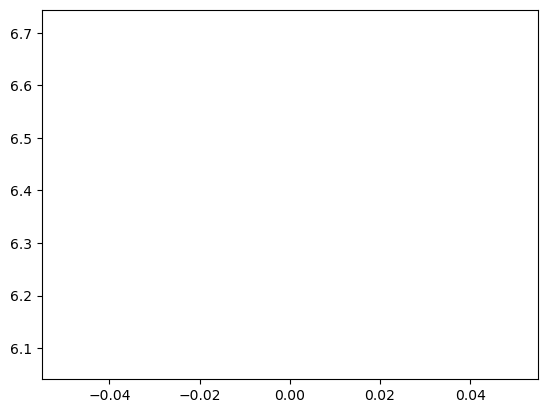

In [19]:
'''
Why do residual connections and layernormalization work?

Layer norm: Even with careful intialization, all gradients are dependent on previous layers. If prev. layers shift in a correlated way
(all vals up/down) it will affect the next gradient, causing uneven optimization of layers (all layers can't capture info now). If we normalize
the inputs to each layer, this will not happen, and the scale of each layer does not affect the next. But neurons can still have more sensitive outputs
this is just learned slowly over time with 'l' and 'b' parameters (scale and shift of neurons' outputs). Gradients are expressive of change,
but not sensitive to scale (all grads on similar scale is good).

Residual connections: Derivatives of every single layer are 'distributed' through addition, causing each layer, at onset to have similar derivatives.
This allows all parts of model to have similar derivatives at start, and then allows for some to take over.

'''

'''
What is adamw, and what types of learning rates allow NN's to work best?

What is L2 regularization vs. weight decay, how are they 'decoupled'?

'''

# fix saving function to make it work!
import matplotlib.pyplot as plt
plt.plot(stepi,lossi)

In [ ]:
m1.generate(torch.zeros(1,1,device=device,dtype=int),900) # generating bigram characters! - No nonlinearities used, 1 layer!